In [1]:
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
import random
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd


/home/alexchen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
a = iter(x)
for i in a:
    first = i
    second = next(a, first)
    third = next(a,first)
    four = next(a, first)
    print(first)
    print(second)
    print(third)
    print(four)
    print("----")
    

1
2
3
4
----
5
6
7
8
----
9
10
9
9
----


In [3]:
from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1,s2,s3), (s1,s2,s3,s4), (s2, s3,s4,s5), ..."
    a, b, c, d = tee(iterable, n=4)
    next(b, None)
    return zip(a, b)

In [4]:
batch_size = 128
n_mixture = 8
std = 0.025
radius = 1.0
latent_z_size =100
epochs = 5000

use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.00002
beta1 = 0.5
dropout = 0.5
data_type = "grid"

#unroll_steps = 4

In [5]:
#ring data
if data_type == "ring":
    thetas = np.linspace(0, 2 * np.pi - 2 * np.pi / n_mixture, n_mixture)
    centers = []
    for i in range(0, len(thetas)):
        centers.append([radius * np.sin(thetas[i]), radius * np.cos(thetas[i])])
    samples = []
    for c in centers:
        samples.extend(np.random.normal(loc=c, scale=std, size=[8192, 2]).tolist())
    #for s in range(len(samples)):
    #    samples[s] = tf.convert_to_tensor(samples[s])
    #for z in range(len(samples)):
    #   samples[z] = [samples[z]]

    #test output shape    
    #o = np.array(samples)
    #print(o.shape)

    random.shuffle(samples)
    samples = np.asarray(samples)
    print(samples)
    #print(samples.T[0:3])
    train_data = mx.io.NDArrayIter(data = samples, batch_size = batch_size)

In [6]:
# grid data
if data_type == "grid":
    values = np.linspace(-1, 1, 5)
    centers = []
    for i in range(0, len(values)):
        for j in range(0, len(values)):
            centers.append([values[i], values[j]])
    samples = []
    for c in centers:
        samples.extend(np.random.normal(loc=c, scale=std, size=[8192, 2]).tolist())
    random.shuffle(samples)
    samples = np.asarray(samples)
    print(samples)
    train_data = mx.io.NDArrayIter(data=samples, batch_size = batch_size)


[[-0.45649905 -0.47085972]
 [-0.5045882  -0.51097824]
 [-0.99469664 -0.01472532]
 ...
 [ 0.99402123 -0.52217324]
 [-0.97255589  0.95989916]
 [ 0.02677069 -0.55074801]]


204800
2
[[-0.45649905 -0.5045882  -0.99469664 ...  0.99402123 -0.97255589
   0.02677069]
 [-0.47085972 -0.51097824 -0.01472532 ... -0.52217324  0.95989916
  -0.55074801]]


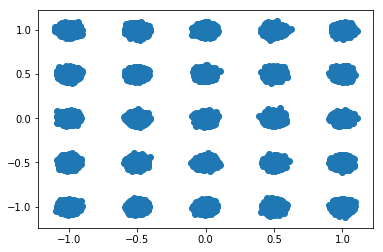

In [7]:
print(len(samples))
print(len(samples[0]))
#print(len(samples[0][0]))
print(samples.T)

x= samples.T[0]
y = samples.T[1]
plt.scatter(x,y)

In [8]:
netG = nn.Sequential()
with netG.name_scope():
    
    #Convolutional
    #initially 128 x 100 x 2
#     netG.add(nn.Conv1DTranspose(50, 4, in_channels = 100, padding = 2, strides =2))
#     netG.add(nn.BatchNorm())
#     netG.add(nn.Activation('relu'))
#     # should now be 128 x 50 x 2
#     netG.add(nn.Conv1DTranspose(25, 4, in_channels = 50, padding = 2, strides =2))
#     netG.add(nn.BatchNorm())
#     netG.add(nn.Activation('relu'))
#     # should still be 128 x 25 x 2
#     netG.add(nn.Conv1DTranspose(5, 4, in_channels = 25, padding = 2, strides =2))
#     netG.add(nn.BatchNorm())
#     netG.add(nn.Activation('relu'))
#     #should still be 128 x 5 x 2
#     netG.add(nn.Conv1DTranspose(2, 4,  in_channels = 5, padding = 2, strides =2))
#     netG.add(nn.BatchNorm())
#     netG.add(nn.Activation('relu'))
#     #should still be 128 x 2 x 2
#     netG.add(nn.Conv1DTranspose(1, 4,  in_channels = 2, padding = 2, strides =2))
#     netG.add(nn.LeakyReLU(0.2))
#     #should still be 128 x 1 x 2
    
    
#     #Dense
#     #initially 128 x 100 x 2
#     netG.add(nn.Dense(400))
#     netG.add(nn.BatchNorm())
#     netG.add(nn.LeakyReLU(0.2))
#     netG.add(nn.Dropout(0.5))
#     #netG.add(nn.Dense(640))
#     #netG.add(nn.LeakyReLU(0.2))
#     netG.add(nn.Dense(400))
#     netG.add(nn.BatchNorm())
#     netG.add(nn.Dropout(0.5))
#     #netG.add(nn.LeakyReLU(0.2))
#     netG.add(nn.Dense(2))



    #Try three smh
    netG.add(nn.Dense(128, activation = "tanh"))
    netG.add(nn.Dense(128, activation = "tanh"))
    netG.add(nn.Dense(2))
    
    

In [9]:
netD1 = nn.Sequential()
with netD1.name_scope():
    
    #Convolutional
    #input is 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
#     netD.add(nn.LeakyReLU(0.2))
#     # should still be 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
#     netD.add(nn.BatchNorm())
#     netD.add(nn.LeakyReLU(0.2))
#     # should still be 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
#     netD.add(nn.BatchNorm())
#     netD.add(nn.LeakyReLU(0.2))
#     # should still be 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
#     netD.add(nn.BatchNorm())
#     netD.add(nn.LeakyReLU(0.2))
#     # should still be 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, strides = 2,padding = 2, in_channels = 1))
#     # should still be 256 x 1 x 1


    #Dense
    netD1.add(nn.Dense(200))
    netD1.add(nn.Dropout(0.5))
    netD1.add(nn.LeakyReLU(0.2))
    #netD.add(nn.Dense(100))
    #netD.add(nn.LeakyReLU(0.2))
    netD1.add(nn.Dense(200))
    netD1.add(nn.LeakyReLU(0.2))
    #netD.add(nn.Dropout(0.5))
    netD1.add(nn.Dense(1))
    
    
    
    #Try three smh
    
#     netD1.add(nn.Dense(128, activation = "tanh"))
#     netD1.add(nn.Dense(128, activation = "tanh"))
#     netD1.add(nn.Dense(1))

In [10]:
netD2 = nn.Sequential()
with netD2.name_scope():
    
    #Convolutional
    #input is 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
#     netD.add(nn.LeakyReLU(0.2))
#     # should still be 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
#     netD.add(nn.BatchNorm())
#     netD.add(nn.LeakyReLU(0.2))
#     # should still be 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
#     netD.add(nn.BatchNorm())
#     netD.add(nn.LeakyReLU(0.2))
#     # should still be 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
#     netD.add(nn.BatchNorm())
#     netD.add(nn.LeakyReLU(0.2))
#     # should still be 256 x 1 x 2
#     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, strides = 2,padding = 2, in_channels = 1))
#     # should still be 256 x 1 x 1


    #Dense
    netD2.add(nn.Dense(256))
    netD2.add(nn.Dropout(0.5))
    netD2.add(nn.LeakyReLU(0.2))
    #netD.add(nn.Dense(100))
    #netD.add(nn.LeakyReLU(0.2))
    netD2.add(nn.Dense(200))
    netD2.add(nn.LeakyReLU(0.2))
    #netD.add(nn.Dropout(0.5))
    netD2.add(nn.Dense(1))



    #Try three smh
    #netD2.add(nn.Dense(128, activation = "tanh"))
    #netD2.add(nn.Dense(128, activation = "tanh"))
    #netD2.add(nn.Dense(1))
    
    

In [11]:
# netD3 = nn.Sequential()
# with netD3.name_scope():
    
#     #Convolutional
#     #input is 256 x 1 x 2
# #     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
# #     netD.add(nn.LeakyReLU(0.2))
# #     # should still be 256 x 1 x 2
# #     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
# #     netD.add(nn.BatchNorm())
# #     netD.add(nn.LeakyReLU(0.2))
# #     # should still be 256 x 1 x 2
# #     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
# #     netD.add(nn.BatchNorm())
# #     netD.add(nn.LeakyReLU(0.2))
# #     # should still be 256 x 1 x 2
# #     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, padding = 2, in_channels = 1))
# #     netD.add(nn.BatchNorm())
# #     netD.add(nn.LeakyReLU(0.2))
# #     # should still be 256 x 1 x 2
# #     netD.add(nn.Conv1D(channels = 1, kernel_size = 5, strides = 2,padding = 2, in_channels = 1))
# #     # should still be 256 x 1 x 1


# #     #Dense
# #     netD2.add(nn.Dense(256))
# #     netD2.add(nn.Dropout(0.5))
# #     netD2.add(nn.LeakyReLU(0.2))
# #     #netD.add(nn.Dense(100))
# #     #netD.add(nn.LeakyReLU(0.2))
# #     netD2.add(nn.Dense(200))
# #     netD2.add(nn.LeakyReLU(0.2))
# #     #netD.add(nn.Dropout(0.5))
# #     netD2.add(nn.Dense(1))



#     #Try three smh
#     netD3.add(nn.Dense(128, activation = "tanh"))
#     netD3.add(nn.Dense(128, activation = "tanh"))
#     netD3.add(nn.Dense(1))
    
    

In [12]:
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

netG.initialize(mx.init.Normal(0.095), ctx = ctx)
netD1.initialize(mx.init.Normal(0.095), ctx = ctx)
netD2.initialize(mx.init.Normal(0.095), ctx = ctx)

trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1':beta1})
trainerD1 = gluon.Trainer(netD1.collect_params(), 'adam', {'learning_rate': lr, 'beta1':beta1})
trainerD2 = gluon.Trainer(netD2.collect_params(), 'adam', {'learning_rate': lr, 'beta1':beta1})
#unrolledtrainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1':beta1})


In [1]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size * 4,), ctx = ctx)
fake_label = nd.zeros((batch_size * 4,), ctx = ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred>0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)


stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)
print("Begin")




print("BEFORE THE FIRE:")
latent1 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
fake = netG(latent1)
print(fake)
for i in range(5):
    latent = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
    fakeadd = netG(latent)
    x = fakeadd.T[0].asnumpy().tolist()
    y = fakeadd.T[1].asnumpy().tolist()
    print("Plot %d" % i)
    plt.scatter(x,y)
    plt.show()
    fake = mx.ndarray.concat(fake, fakeadd, dim = 0)
    
print("Good luck bud")





#set up Discriminator first

for i in range(100):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    #print("RUNNING")
    for batch1 in train_data:
        batch2 = next(train_data, batch1)
        batch3 = next(train_data, batch1)
        batch4 = next(train_data, batch1)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        data = (mx.ndarray.concat(batch1.data[0], batch2.data[0], batch3.data[0], batch4.data[0], dim = 0)).as_in_context(ctx)
        
        #test new shape for data
        
        
        
        #print(data)
        #if iter == 0:
            #x = data.T[0].asnumpy().tolist()
            #y = data.T[1].asnumpy().tolist()
            #print(x)
            #print(y)
            #plt.scatter(x,y)
            #plt.show()
            
        
        
        noise = mx.ndarray.random_normal(0, 0.1, batch_size * 4, ctx = ctx)
        real_label_noise = mx.ndarray.add(real_label, noise)
        noise = mx.ndarray.random_normal(0, 0.1, batch_size * 4, ctx = ctx)
        fake_label_noise = mx.ndarray.add(fake_label, noise)
        #print("TESTING 123")
        #print(real_label_noise)
        #print(fake_label_noise)
        #print("THIS IS A CHECK")
        #print(data)
        #print(len(data))
        #print(len(data[0]))
        #print(len(data[0][0]))
        #print(len(batch1.data[0]))
        #print(len(batch1.data[0][0]))
        #print(len(batch1.data[0][0][0]))
        #print(len(batch2.data[0]))
        #print(len(batch2.data[0][0]))
        #print(len(batch2.data[0][0][0]))
        #print(data)
        
        
        latent_z1 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        latent_z2 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        latent_z3 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        latent_z4 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)

        with autograd.record():
            # train with real image
            #print("Real Data")
            #print(data)
            output = netD1(data).reshape((-1, 1))
            #print("Output of Discriminator")
            #print(output)
            errD1_real = loss(output, real_label_noise)
            #print("This is the guess for real")
            #print(output)
            metric.update([real_label,], [output,])

            # train with fake image
            firstFake = netG(latent_z1)
            secondFake = netG(latent_z2)
            thirdFake = netG(latent_z3)
            fourthFake = netG(latent_z4)
            #print("testing 1")
            #print(firstFake)
            
            #only add if using dense
            #firstFake = firstFake.reshape((128, 1, 2))
            #secondFake = secondFake.reshape((128, 1, 2))  
            #print("testing 2")
            #print(firstFake)
            

            fake = mx.ndarray.concat(firstFake, secondFake, thirdFake, fourthFake, dim = 0)
            #print(fake)
            #print(fake)
            #print("TESTING")
            #print(len(fake))
            output = netD1(fake.detach()).reshape((-1, 1))
            errD1_fake = loss(output, fake_label_noise)
            errD1 = errD1_real + errD1_fake
            errD1.backward()
            metric.update([fake_label,], [output,])

        trainerD1.step(data.shape[0])
        
        with autograd.record():
            # train with real image
            #print("Real Data")
            #print(data)
            output = netD2(data).reshape((-1, 1))
            #print("Output of Discriminator")
            #print(output)
            errD2_real = loss(output, real_label_noise)
            #print("This is the guess for real")
            #print(output)
            metric.update([real_label,], [output,])

            # train with fake image
            firstFake = netG(latent_z1)
            secondFake = netG(latent_z2)
            thirdFake = netG(latent_z3)
            fourthFake = netG(latent_z4)
            #print("testing 1")
            #print(firstFake)
            
            #only add if using dense
            #firstFake = firstFake.reshape((128, 1, 2))
            #secondFake = secondFake.reshape((128, 1, 2))  
            #print("testing 2")
            #print(firstFake)
            

            fake = mx.ndarray.concat(firstFake, secondFake, thirdFake, fourthFake, dim = 0)
            #print("TESTING")
            #print(len(fake))
            output = netD2(fake.detach()).reshape((-1, 1))
            errD2_fake = loss(output, fake_label_noise)
            errD2 = errD2_real + errD2_fake
            errD2.backward()
            metric.update([fake_label,], [output,])

        trainerD2.step(data.shape[0])
        
        
        
    name, acc = metric.get()
    metric.reset()
    
print("Done setting up Discriminator")
for epoch in range(epochs+1):
    train_data.reset()
    tic = time.time()
    btic = time.time()
    count = 0
    iter = 0
    #print("RUNNING")
    for batch1 in train_data:
        batch2 = next(train_data, batch1)
        batch3 = next(train_data, batch1)
        batch4 = next(train_data, batch1)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        data = (mx.ndarray.concat(batch1.data[0], batch2.data[0], batch3.data[0], batch4.data[0], dim = 0)).as_in_context(ctx)
        #if count == 0:
            #print("Real DATA")
            #x = 
            #plt.scatter(x,y)
            #plt.show()
            
            
            #print("END of Real Data")
        
        
        noise = mx.ndarray.random_normal(0, 0.1, batch_size * 4, ctx = ctx)
        real_label_noise = mx.ndarray.add(real_label, noise)
        noise = mx.ndarray.random_normal(0, 0.1, batch_size * 4, ctx = ctx)
        fake_label_noise = mx.ndarray.add(fake_label, noise)
        #print("THIS IS A CHECK")
        #print(data)
        #print(len(data))
        #print(len(data[0]))
        #print(len(data[0][0]))
        #print(len(batch1.data[0]))
        #print(len(batch1.data[0][0]))
        #print(len(batch1.data[0][0][0]))
        #print(len(batch2.data[0]))
        #print(len(batch2.data[0][0]))
        #print(len(batch2.data[0][0][0]))
        #print(data)
        
        
        latent_z1 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        latent_z2 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        latent_z3 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        latent_z4 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        with autograd.record():
            # train with real image
            #print("Real Data")
            #print(data)
            output = netD1(data).reshape((-1, 1))
            #print("Output of Discriminator")
            #print(output)
            errD1_real = loss(output, real_label_noise)
            #print("This is the guess for real")
            #print(output)
            metric.update([real_label], [output,])

            # train with fake image
            firstFake = netG(latent_z1)
            secondFake = netG(latent_z2)
            thirdFake = netG(latent_z3)
            fourthFake = netG(latent_z4)
            #print("testing 1")
            #print(firstFake)

            #only add if using dense
            #firstFake = firstFake.reshape((128, 1, 2))
            #secondFake = secondFake.reshape((128, 1, 2))  
            #print("testing 2")
            #print(firstFake)


            fake = mx.ndarray.concat(firstFake, secondFake, thirdFake, fourthFake, dim = 0)
            #print("TESTING")
            #print(len(fake))
            output = netD1(fake.detach()).reshape((-1, 1))
            errD1_fake = loss(output, fake_label_noise)
            errD1 = errD1_real + errD1_fake
            errD1.backward()
            metric.update([fake_label,], [output,])

        trainerD1.step(data.shape[0])
        
        with autograd.record():
            # train with real image
            #print("Real Data")
            #print(data)
            output = netD2(data).reshape((-1, 1))
            #print("Output of Discriminator")
            #print(output)
            errD2_real = loss(output, real_label_noise)
            #print("This is the guess for real")
            #print(output)
            metric.update([real_label], [output,])

            # train with fake image
            firstFake = netG(latent_z1)
            secondFake = netG(latent_z2)
            thirdFake = netG(latent_z3)
            fourthFake = netG(latent_z4)
            #print("testing 1")
            #print(firstFake)

            #only add if using dense
            #firstFake = firstFake.reshape((128, 1, 2))
            #secondFake = secondFake.reshape((128, 1, 2))  
            #print("testing 2")
            #print(firstFake)


            fake = mx.ndarray.concat(firstFake, secondFake, thirdFake, fourthFake, dim = 0)
            #print("TESTING")
            #print(len(fake))
            output = netD2(fake.detach()).reshape((-1, 1))
            errD2_fake = loss(output, fake_label_noise)
            errD2 = errD2_real + errD2_fake
            errD2.backward()
            metric.update([fake_label,], [output,])

        trainerD2.step(data.shape[0])
            
            
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake1 = netG(latent_z1)
            fake2 = netG(latent_z2)
            fake3 = netG(latent_z3)
            fake4 = netG(latent_z4)
            #print(fake1)
            #rint(fake1.T)
            #print(fake1.T[0])
           # print(fake1.T[0][1])
            
            
            #only add if using dense
            #fake1 = fake1.reshape((128, 1, 2))
            #fake2 = fake2.reshape((128, 1, 2))
            
            output = netD1(mx.ndarray.concat(fake1, fake2, fake3, fake4, dim = 0)).reshape((-1, 1))
            errG = loss(output, real_label_noise)
            errG.backward()

        trainerG.step(mx.ndarray.concat(batch1.data[0], batch2.data[0], batch3.data[0], batch4.data[0]).shape[0])
        
        with autograd.record():
            fake1 = netG(latent_z1)
            fake2 = netG(latent_z2)
            fake3 = netG(latent_z3)
            fake4 = netG(latent_z4)
            #print(fake1)
            #rint(fake1.T)
            #print(fake1.T[0])
           # print(fake1.T[0][1])
            
            
            #only add if using dense
            #fake1 = fake1.reshape((128, 1, 2))
            #fake2 = fake2.reshape((128, 1, 2))
            
            output = netD2(mx.ndarray.concat(fake1, fake2, fake3, fake4, dim = 0)).reshape((-1, 1))
            errG = loss(output, real_label_noise)
            errG.backward()

        trainerG.step(mx.ndarray.concat(batch1.data[0], batch2.data[0], batch3.data[0], batch4.data[0]).shape[0])
        
        
        

        # Print log infomation every ten batches
        if iter % 10 == 0:
            name, acc = metric.get()
            #logging.firstFake info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            #logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
            #         %(nd.mean(errD).asscalar(),
            #           nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    if acc == 1.0 and epoch >201:
        print("FAIL")
        sys.exit("D too good")
    metric.reset()
    #logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    #logging.info('time: %f' % (time.time() - tic))

    #Visualize one generated image for each epoch
    fake_img = fake1[0]
    #print("testing")
    #print("Fake data")
    #print(fake1)
    ##print("fake data transposed")
    #print(fake1.T)
    #print(len(fake))0
    #print(len(fake[0]))
    #print(len(fake[0][0]))
    #print(fake)
    
    
    #test small print
    #print("epoch %d" % (epoch))
    #print("X: %s   Y: %s  " % (fake_img[0][0],fake_img[0][1]))
    #x= fake.T[0][0].asnumpy().tolist()
    #y = fake.T[1][0].asnumpy().tolist()
    #print("Plot")
    #plt.scatter(x,y)
    #plt.show()
    
    
    
    
    #real print
    if(epoch%100 ==0):
        print("Epoch: %d" % epoch)
    if(epoch%200 == 0):# or epoch % 200 == 1 or epoch % 200 == 2 or epoch % 200 == 3):
        logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
        logging.info('time: %f' % (time.time() - tic))
        logging.info('time: %f' % (time.time() - tic))
        print("epoch %d" % (epoch))
        
        #For convolution?
        #print("X: %s   Y: %s  " % (fake_img[0][0],fake_img[0][1]))
        #x= fake1.T[0][0].asnumpy().tolist()
        #y = fake1.T[0][1].asnumpy().tolist()
        latent1 = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
        fake = netG(latent1)
        for i in range(5):
            latent = mx.nd.random_normal(loc = 0, scale = 3, shape=(batch_size, latent_z_size, 2), ctx=ctx)
            fakeadd = netG(latent)
            x = fakeadd.T[0].asnumpy().tolist()
            y = fakeadd.T[1].asnumpy().tolist()
            print("Plot %d" % i)
            plt.scatter(x,y)
            plt.show()
            fake = mx.ndarray.concat(fake, fakeadd, dim = 0)
        #fake = mx.ndarray.concat(fake1, fake2, fake3, fake4, dim = 0)
        

        #print("X: ")
        #print(fake.T[0][0])
        #print("Y: ")
        #print(fake.T[0][1])
        #print("")
        #print("")
        print(fake)


        #plt.show()   
    
    # visualize(fake_img)
    # plt.show()


NameError: name 'nd' is not defined